In [1]:
import simplejson as sjson

In [2]:
data = [] 
with open("../data/fyear/2014.txt") as f:
    for line in f:
        tmp = sjson.loads(line)
        data.append((tmp['gvkey'],tmp['comp_name'],tmp['item_1']))

In [3]:
data = pd.DataFrame(data)

In [5]:
data.columns = ['gvkey','comp_name','item1']

data.head()

,gvkey,comp_name,item1
0,5252,GRACO INC,Item 1. Business Graco Inc. together with its ...
1,121759,ID SYSTEMS INC,Item 1. Business Overview I.D. Systems Inc. wa...
2,5600,HERTZ CORP,ITEM 1. BUSINESS OUR COMPANY We operate our ca...
3,5018,GENCORP INC,Item 1. Business Unless otherwise indicated or...
4,5284,GRAY TELEVISION INC,Item 1. Business. In this annual report on For...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 3 columns):
gvkey        4092 non-null int64
comp_name    4092 non-null object
item1        4092 non-null object
dtypes: int64(1), object(2)
memory usage: 96.0+ KB


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# LDA can only use raw term counts for LDA 
tf_vectorizer = CountVectorizer(max_df=0.90, \
                min_df=50, stop_words='english')
tf = tf_vectorizer.fit_transform(data['item1'])

# each feature is a word (bag of words)
# get_feature_names() gives all words
tf_feature_names = tf_vectorizer.get_feature_names()

print(tf_feature_names[0:10])
print(tf.shape)

# split dataset into train (90%) and test sets (10%)
# the test sets will be used to evaluate proplexity of topic modeling
X_train, X_test = train_test_split(\
                tf, test_size=0.1, random_state=0)

['00', '000', '001', '002', '003', '004', '005', '006', '007', '008']
(4092, 12044)


In [11]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 50

# Run LDA. For details, check
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation.perplexity

# max_iter control the number of iterations 
# evaluate_every determines how often the perplexity is calculated
# n_jobs is the number of parallel threads
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=10,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

/Users/jiahuibi/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 10, perplexity: 2232.5577
iteration: 2 of max_iter: 10, perplexity: 2179.1666
iteration: 3 of max_iter: 10, perplexity: 2160.1704
iteration: 4 of max_iter: 10, perplexity: 2150.6553
iteration: 5 of max_iter: 10, perplexity: 2144.9032
iteration: 6 of max_iter: 10, perplexity: 2140.9516
iteration: 7 of max_iter: 10, perplexity: 2138.0232
iteration: 8 of max_iter: 10, perplexity: 2135.7015
iteration: 9 of max_iter: 10, perplexity: 2133.8137
iteration: 10 of max_iter: 10, perplexity: 2132.2823


In [12]:
num_top_words=20

# lda.components_ returns a KxN matrix
# for word distribution in each topic.
# Each row consists of 
# probability (counts) of each word in the feature space

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],topic[i]) for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('equipment', 5523.1839872657201), ('fuel', 3830.0307128016379), ('transportation', 3248.376060220095), ('customer', 2296.5798889660532), ('freight', 1991.8140478709329), ('fleet', 1938.3573432894152), ('rental', 1617.6056113807695), ('truck', 1473.848445419753), ('safety', 1433.2401483188225), ('carriers', 1307.4843030379609), ('lease', 1240.9583992273315), ('revenue', 1240.6254787435951), ('maintenance', 1156.3610121572347), ('logistics', 1126.9880926293515), ('insurance', 1104.1450140484274), ('segment', 1091.8175149621009), ('independent', 1015.6368891754065), ('engines', 1002.5823667653882), ('network', 1001.6384056634687), ('engine', 991.15530808142455)]


Topic 1:
[('product', 22610.433730318524), ('manufacturing', 19065.046848089358), ('materials', 9942.7887312448202), ('technology', 9417.1464446309747), ('components', 9223.5204412127368), ('customer', 8655.8482294597943), ('applications', 8556.9111060189553), ('suppliers', 8416.1593131460886), ('production', 8073.048

## Evaluate Topic Models：Perplexity

In [16]:
import numpy as np
import matplotlib.pyplot as plt

result=[]
topic_number=[50,100,150,200]
for num_topics in topic_number:
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=10,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    p=lda.perplexity(X_test)
    result.append([num_topics,p])
    print(num_topics, p)

50 2814.41420412
100 3038.63092516
150 3046.79407413
200 3109.74278674


In [17]:
result=[]

for num_topics in range(2,50):
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=10,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    p=lda.perplexity(X_test)
    result.append([num_topics,p])
    print(num_topics, p)

2 3137.27786636
3 2971.14454313
4 2837.73140657
5 2764.38494496
6 2735.95359989
7 2701.38781325
8 2656.57509662
9 2664.74575221
10 2624.93539439
11 2554.27689991
12 2644.44130444
13 2557.2397904
14 2636.45364393
15 2581.04642258
16 2643.58108425
17 2603.42424368
18 2594.14325976
19 2628.48695308
20 2623.20056966
21 2646.13461754
22 2653.89974505
23 2648.2104458
24 2652.04439323
25 2681.48566933
26 2682.22038637
27 2668.79988381
28 2672.9654098
29 2692.15605061
30 2682.35320918
31 2690.8559957
32 2713.800869
33 2703.06491088
34 2748.16289907
35 2737.51573398
36 2727.1131662
37 2761.89209862
38 2753.6887866
39 2786.36432883
40 2777.1392417
41 2786.90729387
42 2775.45459331
43 2804.21480436
44 2806.26369682
45 2832.69863851
46 2803.31995018
47 2800.72124705
48 2824.92862614
49 2828.87072822


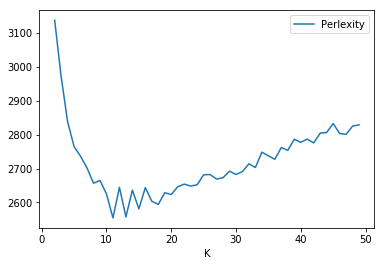

In [18]:
pd.DataFrame(result, columns=["K", "Perplexity"]).plot.line(x='K',y="Perplexity");
plt.show();